# LIBRARIES

In [1]:
## import torch
import torchvision
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from torch.nn import functional as F
import time
import pandas as pd 
from random import shuffle
import seaborn as sns


# Pull in MNIST Data

## MNIST Data Label Generation

In [2]:
def gen_mnist():
    from sklearn.datasets.base import get_data_home 
    from sklearn.datasets import fetch_mldata
    print (get_data_home())
    mnist_raw = fetch_mldata('MNIST original', data_home=get_data_home())
    mnist=mnistData(mnist_raw.target,mnist_raw.data) 
    cnt=len(mnist.label)
    labelset=torch.tensor(mnist.label)
    labelset.shape
    dataset=torch.tensor(mnist.x,dtype=torch.float)
    number_columns=dataset.shape[1]
    dataset = dataset.view(-1,number_columns).float()/256.0
    print(dataset.shape)
    dataset=dataset.view(cnt,28,28)
    return(labelset, dataset)

# Functions

In [3]:
from torch.autograd import Variable
def row_pairwise_euclid(x, y=None, dist_mat=None):
    if y is None:
        y = x
    if dist_mat is None:
        dtype = x.data.type()
        dist_mat = Variable(torch.Tensor(x.size()[0], y.size()[0]).type(dtype))

    for i, row in enumerate(x.split(1)):
        r_v = row.expand_as(y)
        sq_dist = torch.sum((r_v - y) ** 2, 1)
        dist_mat[i] = sq_dist.view(1, -1)
    return dist_mat


from torch.autograd import Variable
def row_pairwise_cosine(x, y=None, dist_mat=None):
    if y is None:
        y = x
    if dist_mat is None:
        dtype = x.data.type()
        dist_mat = Variable(torch.Tensor(x.size()[0], y.size()[0]).type(dtype))

    for i, row in enumerate(x.split(1)):
        r_v = row.expand_as(y)
        sq_dist = F.cosine_similarity(r_v, y)
        dist_mat[i] = sq_dist.view(1, -1)
    return dist_mat

In [4]:
def loss_function(recon_x, x):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    return(BCE)
def decode_loader(data, batch_size):
    perm = torch.randperm(data.size(0))
    idx = perm[:batch_size]
    batch=data[idx]
    return(batch)
def export_tensor(out_tensor,filename):
    arr = out_tensor.data.cpu().numpy()
    # write CSV
    np.savetxt(filename, arr)
def import_tensor(filename):
    from numpy import genfromtxt
    test = np.genfromtxt(filename)
    import_tensor=torch.tensor(test, dtype=torch.float)
    return(import_tensor)
def import_saved_output(filenames,loss_filename):
    imp_data=[]
    for i in range(0,len(filenames)):
        out_file='output/'+filenames[i]+'.csv'
        test=import_tensor(out_file)
        imp_data.append(test)
    test_lossvec = np.genfromtxt(loss_filename)
    return(imp_data, test_lossvec)
def return_cosine(omega):
    cosine_tensor=row_pairwise_cosine(omega)
    size=len(cosine_tensor[0])
    cosine=[]
    for i in range(0,size):
        for j in range(0,size):
            if i!=j:
                cosine.append(abs(cosine_tensor[i][j].item()))
    return(cosine)
def normalize(case):
    matrix=case.detach().cpu().numpy()
    matrix=matrix.transpose()
    mins_vec=[]
    maxs_vec=[]
    for val in matrix:
        mins_vec.append(abs(min(val)))
        maxs_vec.append(abs(max(val)))
    maxs_vec=torch.tensor(maxs_vec, dtype=torch.float)
    mins_vec=torch.tensor(mins_vec, dtype=torch.float)
    denom=torch.sub(maxs_vec,mins_vec)
    #print(maxs_vec)
    #print(mins_vec)
    start=True
    for vector in case:
        new=torch.abs(vector)
        new=torch.sub(new,mins_vec)
        new=torch.div(new,denom)
        new[torch.isnan(new)] = 0        
        if start==True:
            vals=new
            start=False
        else:
            vals=torch.cat((vals,new),0)
    dim=len(case[0])
    inst=len(case)
    vals=vals.view(inst,dim)
    return vals, maxs_vec, mins_vec
    

# Data Generation

## Pull Indices and Labels

In [5]:
def get_images(img_return_cnt,labels_raw, data_raw):
    found=False
    img_agg_cnt=np.zeros(10)
    img_return_cnt=np.array(img_return_cnt)
    i=0
    labels=[]
    indices=[]
    while found==False and 70000>i:
        target=labels_raw[i]
        index=int(labels_raw[i].data)
        if np.dot(np.subtract(img_agg_cnt, img_return_cnt),np.ones(10))==0:
            found=True
        else:
            if img_agg_cnt[index] < img_return_cnt[index]:
                img_agg_cnt[index]+=1
                indices.append(i)
        i+=1
    return(indices)

## Gen Random Embeddings

In [6]:
def gen_rand_data(img_return_cnt,labels_raw, data_raw,Rdim):
    #num_img_type= scalar= equal to the number of image categories
    #img_return_cnt = array = index of array is the image type and value is sample size for image type
    #example_data = data loader data in form: batch_idx, (example_data, example_targets) 
    #max_i= data size
    #Rdim= vector dimension for rand generation
    #img_return_cnt = array = index of array is the image type and value is sample size for image type
    found=False
    img_agg_cnt=np.zeros(10)
    img_return_cnt=np.array(img_return_cnt)
    i=0
    first=True
    labels=[]
    indices=[]
    while found==False and 70000>i:
        target=labels_raw[i]
        index=int(labels_raw[i].data)
        if np.dot(np.subtract(img_agg_cnt, img_return_cnt),np.ones(10))==0:
            found=True
        else:
            if img_agg_cnt[index] < img_return_cnt[index]:
                labels.append(target.item())
                datum=data_raw[i].view(-1,28*28)
                img_agg_cnt[index]+=1
                indices.append(i)
                if first==True:
                    x_tensor=datum
                    randEnc_tensor=torch.rand(1, Rdim)
                    first=False 
                else:
                    omega=torch.rand(1, Rdim)
                    x_tensor=torch.cat((x_tensor,datum),0)
                    randEnc_tensor=torch.cat((randEnc_tensor,omega),0)
        i+=1
    data = rgenData(randEnc_tensor, x_tensor)
    return(data, labels, indices)

## Create RandEmbedding with Image Index

In [7]:
def get_randenc_byindex(indices, labels_raw, data_raw,Rdim):
    #num_img_type= scalar= equal to the number of image categories
    #img_return_cnt = array = index of array is the image type and value is sample size for image type
    #example_data = data loader data in form: batch_idx, (example_data, example_targets) 
    #max_i= data size
    #Rdim= vector dimension for rand generation
    #img_return_cnt = array = index of array is the image type and value is sample size for image type
    i=0
    cnt=len(indices)
    labels=[]
    datum=data_raw[indices[0]].view(-1,28*28)
    x_tensor=datum
    randEnc_tensor=torch.rand(1, Rdim)
    labels.append(labels_raw[0])
    for i in range(1,len(indices)):
        index=indices[i]
        labels.append(labels_raw[index])
        datum=data_raw[index].view(-1,28*28)
        omega=torch.rand(1, Rdim)
        x_tensor=torch.cat((x_tensor,datum),0)
        randEnc_tensor=torch.cat((randEnc_tensor,omega),0)
    data = rgenData(randEnc_tensor, x_tensor)
    return(data, labels)

## Gen Dataset Given Image Index & Array of Embedding

In [8]:
def get_enc_img(indices,labels_raw, data_raw,embedding):
    #num_img_type= scalar= equal to the number of image categories
    #img_return_cnt = array = index of array is the image type and value is sample size for image type
    #example_data = data loader data in form: batch_idx, (example_data, example_targets) 
    #max_i= data size
    #Rdim= vector dimension for rand generation
    #img_return_cnt = array = index of array is the image type and value is sample size for image type
    i=0
    cnt=len(indices)
    labels=[]
    datum=data_raw[indices[0]].view(-1,28*28)
    x_tensor=datum
    randEnc_tensor=torch.tensor(embedding[0], dtype=torch.float)
    labels.append(labels_raw[0])
    for i in range(1,len(indices)):
        index=indices[i]
        labels.append(labels_raw[index])
        datum=data_raw[index].view(-1,28*28)
        omega=torch.tensor(embedding[i], dtype=torch.float)
        x_tensor=torch.cat((x_tensor,datum),0)
        randEnc_tensor=torch.cat((randEnc_tensor,omega),0)
    data = rgenData(randEnc_tensor, x_tensor)
    return(data, labels)

In [9]:
def x_xd_plot_compare(data,model,instances): 
    rows=instances
    cols=2
    Rdim=data[0][0].shape
    Rdim=Rdim[0]
    tot=int(instances)*cols
    fig = plt.figure(figsize=(rows, rows))
    plt.tight_layout() 
    # plot with various axes scales
    loc=0
    fig.subplots_adjust(hspace=.5)
    case=0
    while case<(rows):
        # linear
        loc+=1
        tensor=data[case][1].view(28,28)      
        tensor_d=model.decode(data[case][0])
        tensor_d=tensor_d.view(28,28)
        plt.subplot(rows, cols, loc).axis('off')
        plt.imshow(tensor.detach().numpy(),cmap='gray')
        plt.title(str(case))

        loc+=1
        # log
        plt.subplot(rows, cols, loc).axis('off')
        plt.imshow(tensor_d.detach().numpy(),cmap='gray')
        plt.title(str(case))


        if case==0:
            exp_tensor=data[case][1]
            exp_tensor_d=model.decode(data[case][0])
            exp_omega=data[case][0]
        else:
            exp_tensor=torch.cat((exp_tensor,data[case][1]),0)
            exp_tensor_d=torch.cat((exp_tensor_d,model.decode(data[case][0])),0)
            exp_omega=torch.cat((exp_omega, data[case][0]),0)
        case+=1

    plt.show()
    return(exp_tensor.view(instances,784),exp_tensor_d.view(instances,784),exp_omega.view(instances,Rdim))

# Plotting

In [10]:
def plot_compare(x, x_d): 
    rows=len(x)
    cols=2
    fig = plt.figure(figsize=(rows, rows))
    plt.tight_layout() 
    # plot with various axes scales
    loc=0
    fig.subplots_adjust(hspace=.5)
    case=0
    while case<(rows):
        tensor=x[case].view(28,28)      
        tensor_d=x_d[case].view(28,28)
        ########################################
        loc+=1
        plt.subplot(rows, cols, loc).axis('off')
        plt.imshow(tensor.detach().numpy(),cmap='gray')
        plt.title(str(case))

        loc+=1
        # log
        plt.subplot(rows, cols, loc).axis('off')
        plt.imshow(tensor_d.detach().numpy(),cmap='gray')
        plt.title(str(case))
        case+=1
    plt.show()
    return()

# Results Analysis

In [11]:
min_BCE=[]

In [12]:
#inst=len(imp_loss_array[0])
#subset=np.random.randint(200, size=16)
#print(subset)
subset_200=[114, 134, 171,  41, 146, 186,  35, 129,  67,  62,  35,  31, 116,
        36, 103,  57]
subset_100=[87, 35, 50,  2, 13, 46, 64, 84, 63, 73, 42, 15, 69, 29, 95, 18]
subset_50=[ 2,  9, 13,  2,  1,  6,  8,  8, 11,  4,  9,  9,  3, 14,  9,  0]
subset_16=[12, 11,  9,  5,  9,  6, 15,  7,  8,  5,  0, 13,  6,  9,  3,  1]

In [13]:
# Pull Images to go with ETF
'''
ind_shuffle=[24755, 48200, 1, 18624, 0, 24754, 12666, 30596, 54051, 30597, 5924, 18623, 41935, 12665, 36017, 5923]
embedding=np.matrix([[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1],
[1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1],
[1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1],
[1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1],
[1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1],
[1, -1, -1, 1,-1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1]])
embedding=embedding.transpose()
embedding=torch.tensor(embedding, dtype=torch.float)

print(row_pairwise_cosine(embedding))'''

'\nind_shuffle=[24755, 48200, 1, 18624, 0, 24754, 12666, 30596, 54051, 30597, 5924, 18623, 41935, 12665, 36017, 5923]\nembedding=np.matrix([[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1],\n[1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1],\n[1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1],\n[1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1],\n[1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1],\n[1, -1, -1, 1,-1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1]])\nembedding=embedding.transpose()\nembedding=torch.tensor(embedding, dtype=torch.float)\n\nprint(row_pairwise_cosine(embedding))'

In [14]:
all_loss_array=[]
all_omega_array=[]
bin_cnt=30

# R50

## 2000 Img


EXP
1
tensor([0.4840, 0.9897, 0.8941, 0.4991, 0.4811, 0.5804, 0.0908, 0.8735, 0.7939,
        0.5216, 0.4830, 0.3225, 0.2758, 0.5154, 0.1660, 0.7640, 0.4474, 0.2218,
        0.1408, 0.2474, 0.8506, 0.3112, 0.5238, 0.5834, 0.0597, 0.5999, 0.3554,
        0.9139, 0.9466, 0.4343, 0.3810, 0.4183, 0.4068, 0.3496, 0.3289, 0.2949,
        0.8441, 0.6894, 0.6023, 0.3788, 0.8886, 0.3377, 0.9427, 0.9022, 0.4433,
        0.0674, 0.3096, 0.2107, 0.7331, 0.7859])


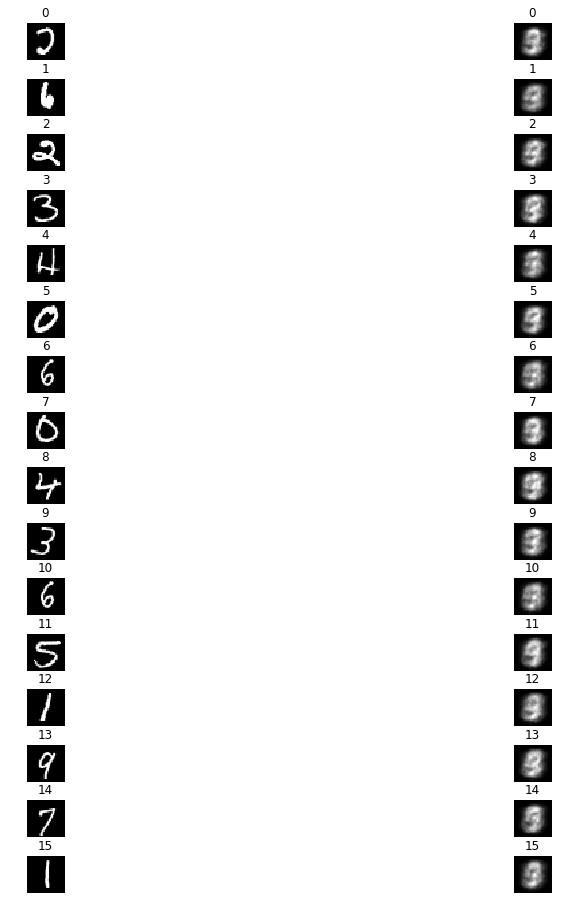


EXP
2
tensor([0.4840, 0.9897, 0.8941, 0.4991, 0.4811, 0.5804, 0.0908, 0.8735, 0.7939,
        0.5216, 0.4830, 0.3225, 0.2758, 0.5154, 0.1660, 0.7640, 0.4474, 0.2218,
        0.1408, 0.2474, 0.8506, 0.3112, 0.5238, 0.5834, 0.0597, 0.5999, 0.3554,
        0.9139, 0.9466, 0.4343, 0.3810, 0.4183, 0.4068, 0.3496, 0.3289, 0.2949,
        0.8441, 0.6894, 0.6023, 0.3788, 0.8886, 0.3377, 0.9427, 0.9022, 0.4433,
        0.0674, 0.3096, 0.2107, 0.7331, 0.7859])


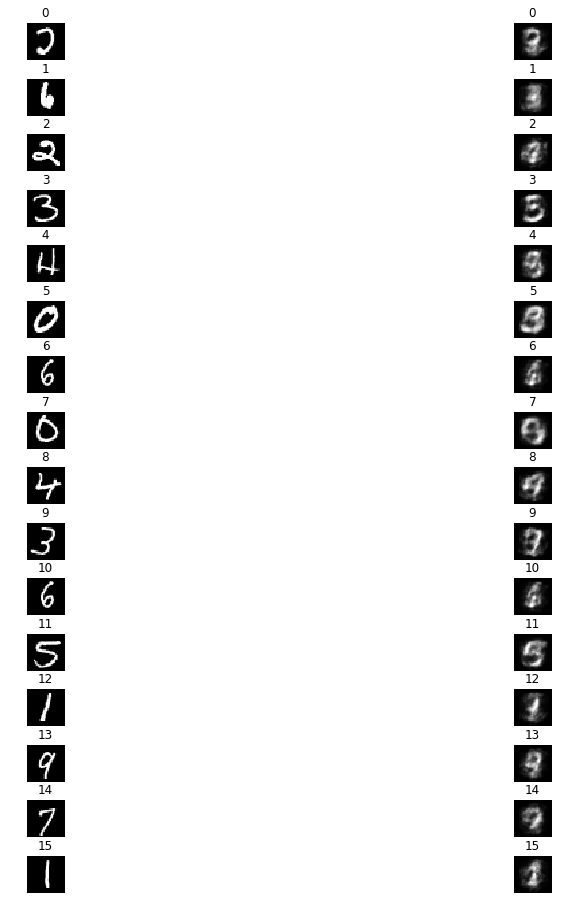


EXP
3
tensor([0.4840, 0.9897, 0.8941, 0.4991, 0.4811, 0.5804, 0.0908, 0.8735, 0.7939,
        0.5216, 0.4830, 0.3225, 0.2758, 0.5154, 0.1660, 0.7640, 0.4474, 0.2218,
        0.1408, 0.2474, 0.8506, 0.3112, 0.5238, 0.5834, 0.0597, 0.5999, 0.3554,
        0.9139, 0.9466, 0.4343, 0.3810, 0.4183, 0.4068, 0.3496, 0.3289, 0.2949,
        0.8441, 0.6894, 0.6023, 0.3788, 0.8886, 0.3377, 0.9427, 0.9022, 0.4433,
        0.0674, 0.3096, 0.2107, 0.7331, 0.7859])


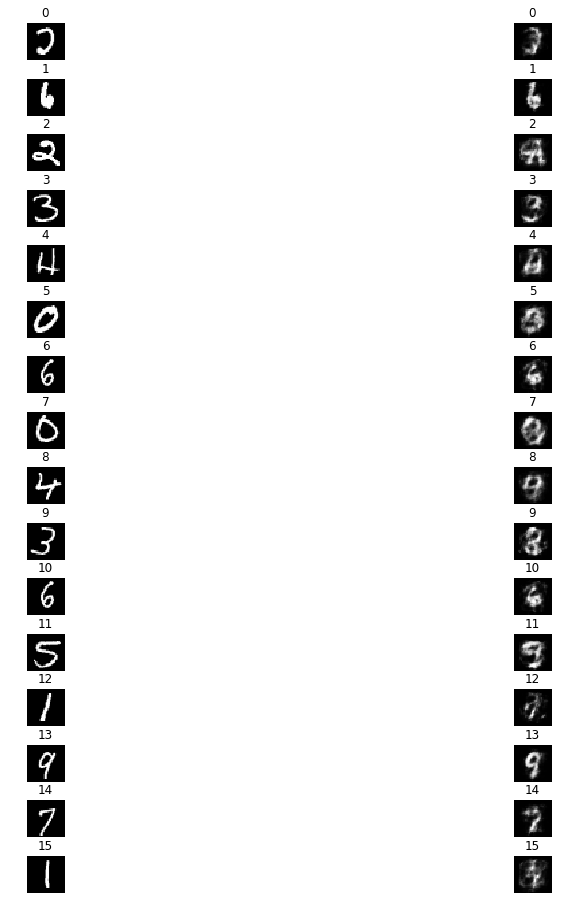


EXP
4
tensor([0.0000e+00, 1.2917e+00, 3.5983e-01, 1.6289e+00, 9.7778e+00, 1.3075e+00,
        4.5362e+00, 3.0993e+00, 5.7175e+00, 2.0809e+00, 5.8448e+00, 4.2075e+00,
        5.5125e+00, 1.7807e+00, 4.6942e+00, 3.6456e+00, 7.5340e+00, 4.3221e+00,
        6.3761e-01, 1.0784e+01, 1.0731e+00, 1.9708e+00, 7.2206e+00, 1.1059e+00,
        4.6973e+00, 7.8902e+00, 5.3275e+00, 5.9794e-01, 8.1868e-03, 6.7789e+00,
        3.6019e-01, 0.0000e+00, 4.3209e+00, 3.3147e+00, 2.6862e+00, 4.9259e+00,
        5.7507e-01, 4.6112e+00, 1.9385e+00, 5.8110e-01, 4.4270e+00, 1.1721e+00,
        2.7616e-01, 3.9509e+00, 0.0000e+00, 4.1955e+00, 0.0000e+00, 8.3513e-01,
        1.4260e+00, 3.2488e+00])


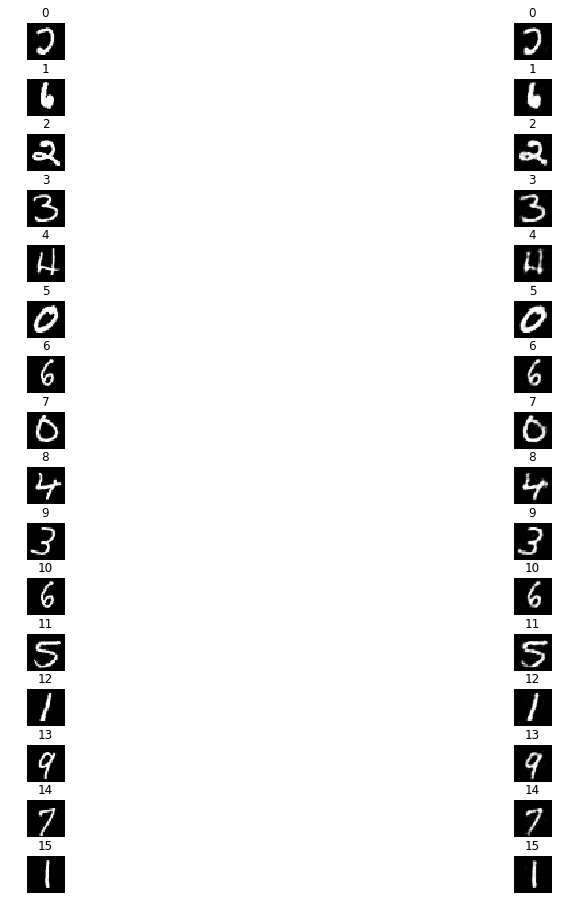


EXP
5
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0606,  0.0000,  0.0000,  0.0000,
         0.0000,  0.5172, 12.2958,  0.0000,  0.0000,  0.0000, 13.7481,  1.0144,
         0.0000,  9.8432,  6.5073,  0.4534, 11.0327,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  8.5118,  3.5417,  0.0000,
         0.0000,  0.0000,  0.0000,  1.5861,  0.0000,  6.0142,  4.3344,  7.9427,
         1.4274,  7.0428,  6.5143,  1.0632,  5.1352,  7.5596,  8.9689,  0.0000,
        11.2917,  0.0000])


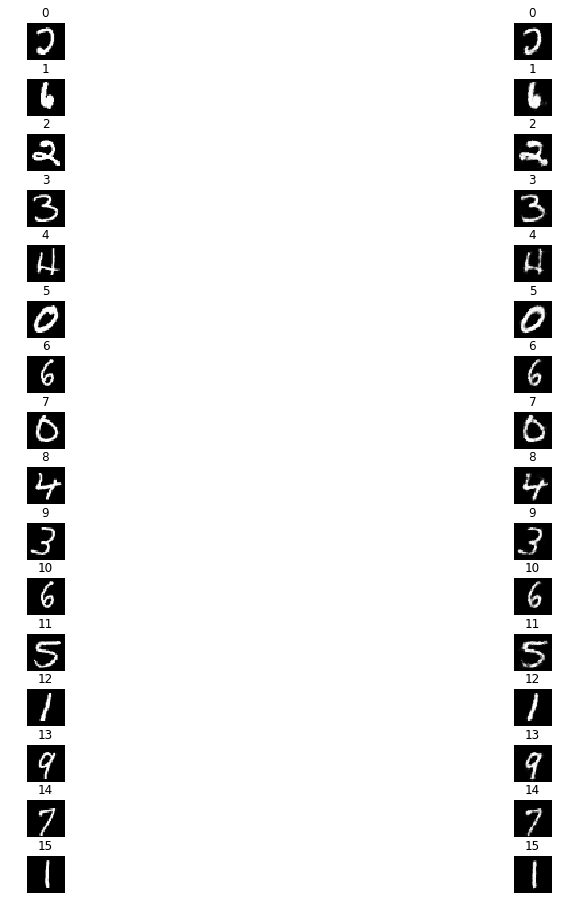


EXP
6
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.4784,  3.2073,  0.0000,
         6.7732,  0.0000,  3.6030,  0.0000,  0.0000,  8.3577,  0.0000,  0.0000,
         0.0000,  0.0000,  7.3422,  0.2447,  6.9388, 11.0308,  0.0000,  0.0000,
         0.0000,  8.0778,  0.0000,  0.0000,  0.0000,  0.0000, 19.6447,  0.0000,
         0.0000,  0.0000,  4.2701,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  8.3587,  0.0000,  0.0000, 14.3443,  0.0000,  0.0000,  9.4681,
         6.6586,  0.0000])


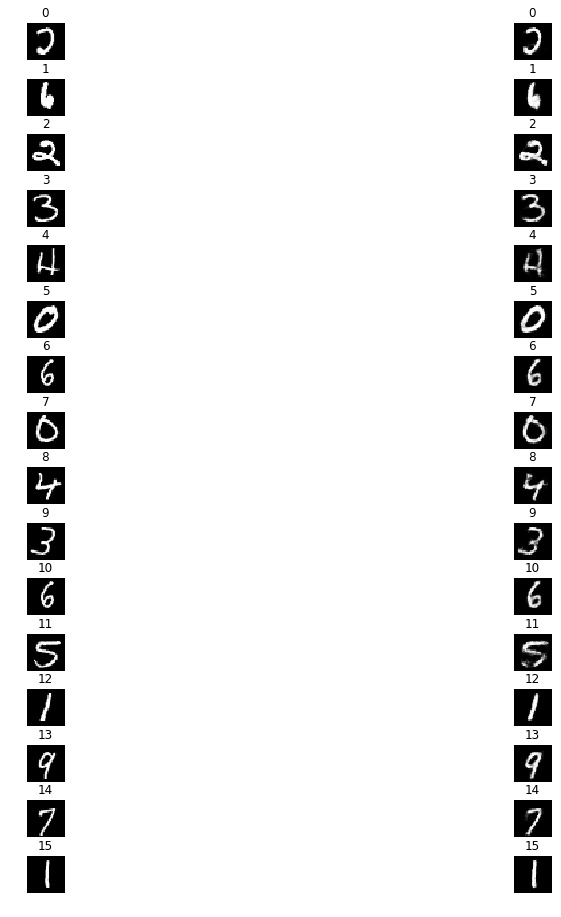


EXP
7
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 28.2770,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         3.9545,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  5.3269,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000, 10.7629,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, 14.5058, 11.9770,  3.0256,  0.0000,  0.0000,  0.0000, 15.7715,
         0.0000, 24.4957])


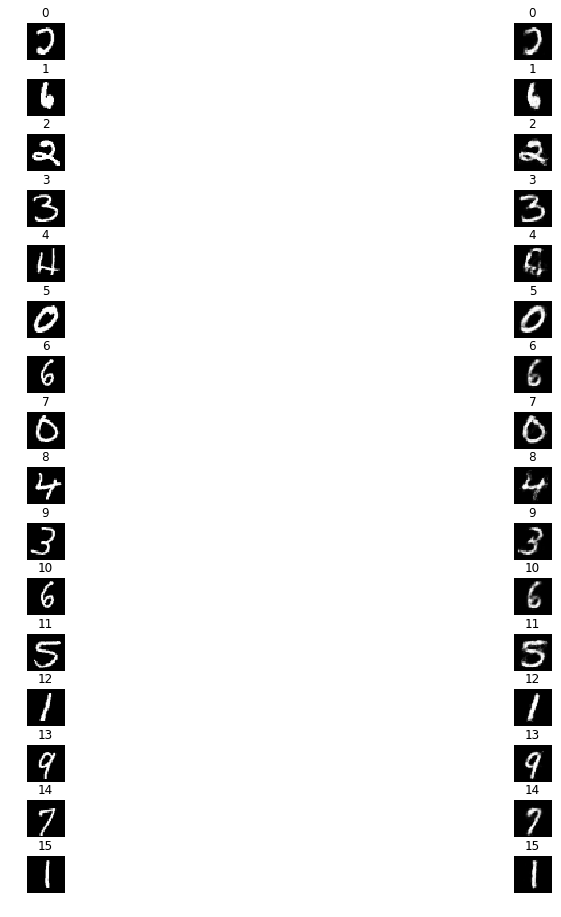


EXP
8
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.4095e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 9.6663e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.8501e-01,
        7.3684e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2102e+00, 0.0000e+00,
        4.9289e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9616e-40,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00])


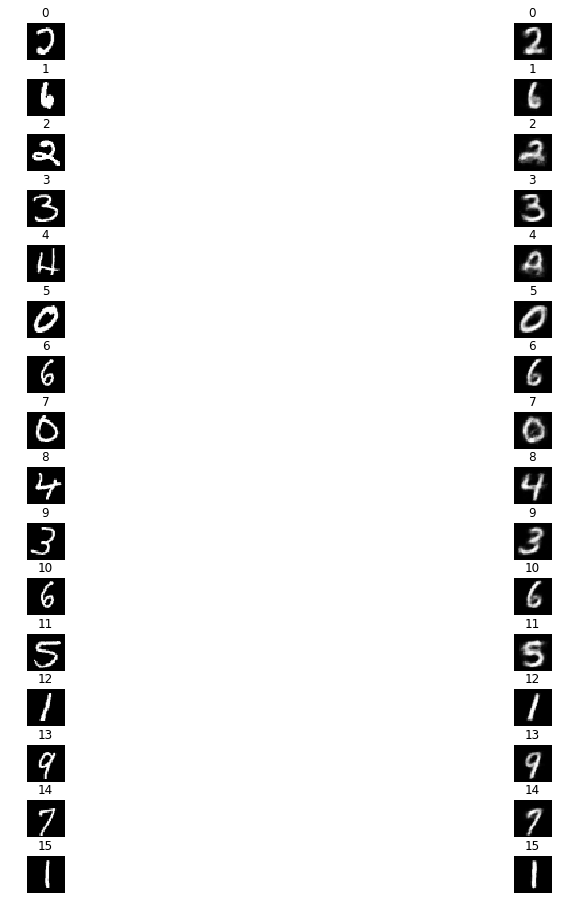


EXP
9
tensor([0.8316, 0.7116, 0.8700, 0.3919, 0.7953, 0.5410, 0.8630, 0.3612, 0.7547,
        0.5549, 0.6421, 0.9755, 0.2833, 0.8747, 0.9016, 0.5100, 0.6375, 0.5500,
        0.2104, 0.1640, 0.5317, 0.9550, 0.6524, 0.6890, 0.0681, 0.3372, 0.0691,
        0.6983, 0.2382, 0.4661, 0.4679, 0.3929, 0.3375, 0.1381, 0.7605, 0.5524,
        0.5153, 0.8229, 0.0582, 0.0216, 0.1505, 0.7528, 0.8676, 0.4320, 0.8219,
        0.5320, 0.9548, 0.8815, 0.5340, 0.3758])


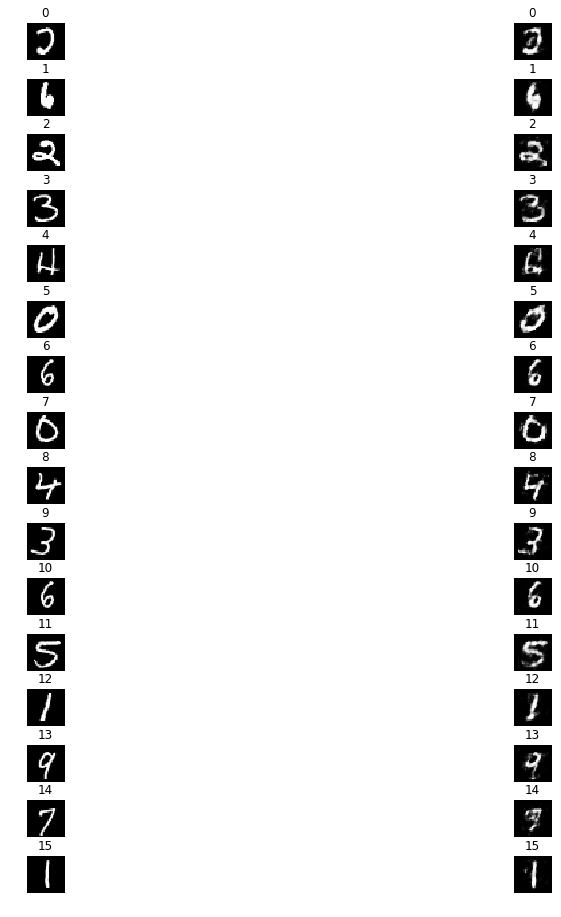


EXP
10
tensor([0.4840, 0.9897, 0.8941, 0.4991, 0.4811, 0.5804, 0.0908, 0.8735, 0.7939,
        0.5216, 0.4830, 0.3225, 0.2758, 0.5154, 0.1660, 0.7640, 0.4474, 0.2218,
        0.1408, 0.2474, 0.8506, 0.3112, 0.5238, 0.5834, 0.0597, 0.5999, 0.3554,
        0.9139, 0.9466, 0.4343, 0.3810, 0.4183, 0.4068, 0.3496, 0.3289, 0.2949,
        0.8441, 0.6894, 0.6023, 0.3788, 0.8886, 0.3377, 0.9427, 0.9022, 0.4433,
        0.0674, 0.3096, 0.2107, 0.7331, 0.7859])


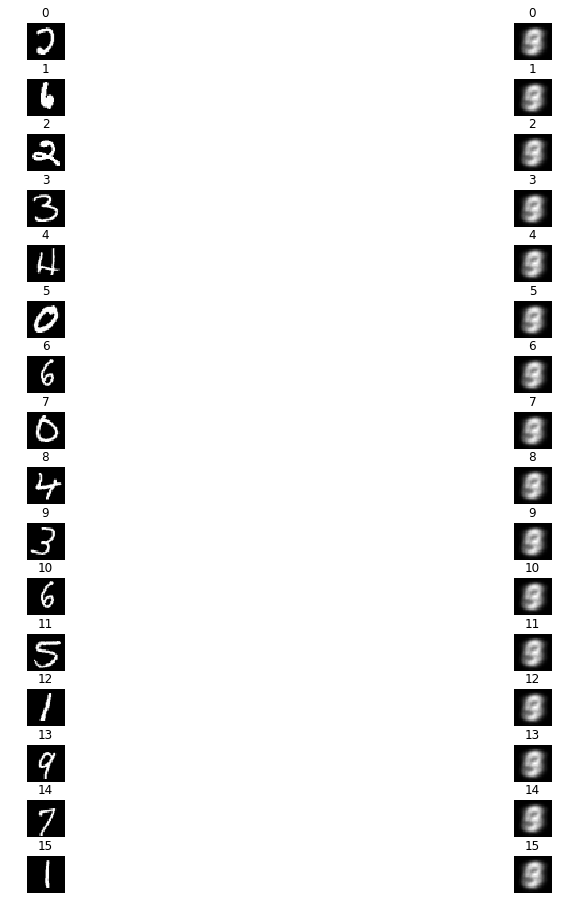

In [15]:
exp_name="R50_Relu_Compare_2000Img_"
subset=subset_200


imp_data_array=[]
imp_loss_array=[]
imp_omega_array=[]

for i in range(1,11):
    exp_num=i
    expnum=str(i)
    tensor_d_name= exp_name+'exp'+expnum+'_tensor_d'
    tensor_name=exp_name+'exp'+expnum+'_tensor'
    omega_name=exp_name+'exp'+expnum+'_omega'
    loss_filename='output/'+exp_name+'exp'+expnum+'_lossvec.csv'
    labels_filename='output/'+exp_name+'exp'+expnum+'_labels_test.csv'
    filenames=[tensor_name, tensor_d_name, omega_name]
    imp_data, test_lossvec=import_saved_output(filenames,loss_filename)
    imp_data_array.append(imp_data)
    imp_loss_array.append(test_lossvec)   
    
all_loss_array.append(imp_loss_array)

loss=[]
i=1

inst=len(imp_loss_array[0])
#subset=np.random.randint(200, size=16)
#print(subset)

for case in imp_data_array:
    print('\nEXP')
    print(i)
    test_tensor=case[0]
    test_tensor_d=case[1] 
    test_omega=case[2] 
    imp_omega_array.append(test_omega)
    print(test_omega[0])
    plt_tensor=[]
    plt_tensor_d=[]
    for sub in subset:
        plt_tensor.append(test_tensor[sub])
        plt_tensor_d.append(test_tensor_d[sub])
    plot_compare(plt_tensor, plt_tensor_d)
    i+=1
    
all_omega_array.append(imp_omega_array)


In [16]:
min_loss=[]
for case in imp_loss_array:
    min_loss.append(case[-1:])
    print(case[-1:])

[0.26266214]
[0.2178434]
[0.17237981]
[0.08220438]
[0.08679543]
[0.09757857]
[0.10627679]
[0.14578788]
[0.10701596]
[0.26437966]


In [17]:
ae_index=[3,4,5,6,7]

model_config_list=["1L-D","2L-D","3L-D","1L-AE","2L-AE","3L-AE","4L-AE","5L-AE","4L-D","5L-D"]
model_config=[]
cosine_array=[]
size=len(return_cosine(imp_omega_array[0]))

for config in model_config_list:
    model_label=np.repeat(config, size)
    model_config.append(model_label.tolist())

for val in range(0,10):
    case=imp_omega_array[val]
    if val in ae_index:
        norm, maxs_vec, mins_vec=normalize(case)
    else:
        norm=case
    cosine_array.append(return_cosine(norm))

col_len=len(cosine_array)*size
model_config=np.array(model_config)
model_config=np.resize(model_config,(1,col_len))
cosine_array=np.array(cosine_array)
cosine_array=np.resize(cosine_array,(1,col_len))

model_config=model_config.tolist()
cosine_array=cosine_array.tolist()

cosine_df=pd.DataFrame()
cosine_df['model_config']=model_config[0]
cosine_df['cosine']=cosine_array[0]

### Plots

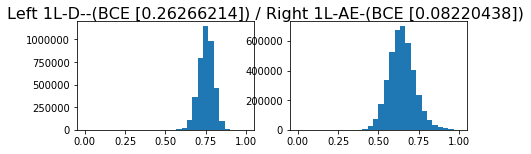

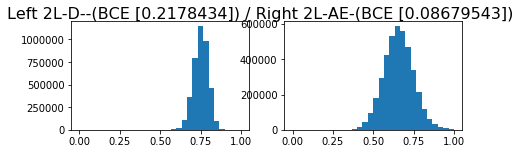

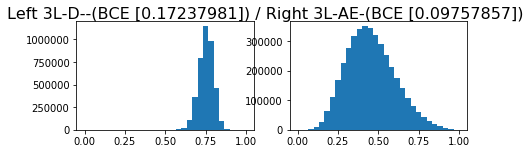

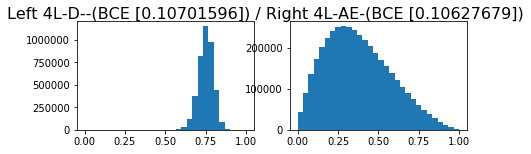

In [18]:
config_pairs=[["1L-D","1L-AE"],["2L-D","2L-AE"],["3L-D","3L-AE"],["4L-D","4L-AE"],["5L-D","5L-AE"]]
index_config=[[0,3],[1,4],[2,5],[8,6],[9,7]]
min_val=0
max_val=1
for i in range(0,4):
    d_label=config_pairs[i][0]
    d_error=min_loss[index_config[i][0]]
    ae_label=config_pairs[i][1]
    ae_error=min_loss[index_config[i][1]]
    decoder=cosine_df.loc[cosine_df['model_config'] == d_label]
    decoder=decoder['cosine']
    ae=cosine_df.loc[cosine_df['model_config'] == ae_label]
    ae=ae['cosine']
    fig, axs = plt.subplots(1, 2,figsize=(7,2))
    title="Left {}--(BCE {}) / Right {}-(BCE {})".format(d_label,d_error, ae_label, ae_error)
    fig.suptitle(title, fontsize=16)
    axs[0].hist(decoder, bins=bin_cnt, range=(min_val,max_val))
    axs[1].hist(ae, bins=bin_cnt, range=(min_val,max_val))

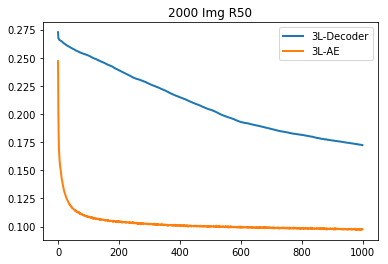

In [19]:
config_groups=['2L-Decoder','3L-Decoder','2L-AE','3L-AE']
data=imp_loss_array


cnt=len(data[1])
cnt_vec=np.arange(0,cnt)
df=pd.DataFrame({'x': cnt_vec, 
                 '2L-Decoder':  np.asarray(data[1]),
                 '3L-Decoder':  np.asarray(data[2]),
                 '2L-AE':  np.asarray(data[4]),
                 '3L-AE':  np.asarray(data[5]),
                })

#plt.plot( 'x','2L-Decoder', data=df, marker='', markerfacecolor='blue', linewidth=1)
plt.plot( 'x','3L-Decoder', data=df, marker='', markerfacecolor='blue', linewidth=2)
#plt.plot( 'x','2L-AE', data=df, marker='', markerfacecolor='blue', linewidth=2)
plt.plot( 'x','3L-AE', data=df, marker='', markerfacecolor='blue', linewidth=2)

plt.title('2000 Img R50')
plt.legend()